In [1084]:
%load_ext autoreload
%autoreload 2

Seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1085]:
#!pip install maldi-nn

In [1086]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

## Parameters

In [1087]:
from src.config import Config
import dill
from src.pretraining_maldi.load_data_maldi import LoadDataMaldi
from src.molecular_pairs_set import MolecularPairsSet
from torch.utils.data import DataLoader, WeightedRandomSampler
from src.pretraining_maldi.embedder_maldi import EmbedderMaldi
from src.losscallback import LossCallback
import lightning.pytorch as pl
import matplotlib.pyplot as plt

In [1088]:
data_folder= '/Users/sebas/projects/data/'
dataset_path= data_folder +'merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'
transformer_path = data_folder + 'best_model_128n_5_layers_20240219_elementwise.ckpt'
results_folder='./notebooks/pretraining/results/'

In [1089]:
THRESHOLD_ANALOG=0.7

In [1090]:
config=Config()

In [1091]:
config.epochs=1000

In [1092]:
config.LR=0.001

## Loading data

In [1093]:
print("loading file")
# Load the dataset from the pickle file
with open(dataset_path, "rb") as file:
    dataset = dill.load(file)

molecule_pairs_train = dataset["molecule_pairs_train"]
molecule_pairs_val = dataset["molecule_pairs_val"]
molecule_pairs_test = dataset["molecule_pairs_test"]
uniformed_molecule_pairs_test = dataset["uniformed_molecule_pairs_test"]

loading file


In [1094]:
spectrums_train=molecule_pairs_train.spectrums
spectrums_val= molecule_pairs_val.spectrums

In [1095]:
import copy

In [1096]:
spectrum_copy=copy.copy(spectrums_train[0])

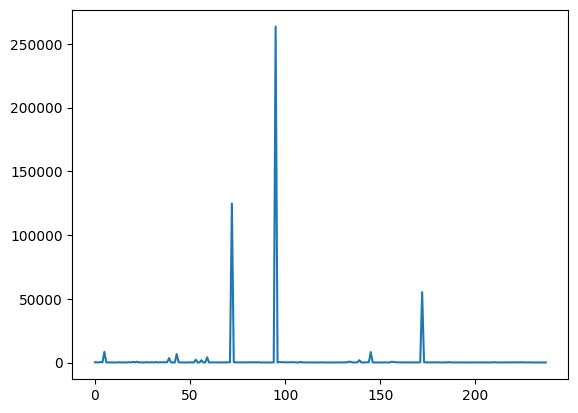

In [1097]:
plt.plot(spectrums_train[0].intensity)

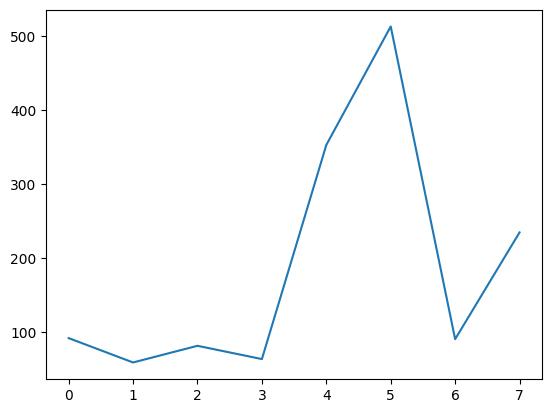

In [1098]:
spectrum_copy=copy.copy(spectrums_train[0])
spectrum_copy.filter_intensity(min_intensity=0.01, max_num_peaks=100).scale_intensity('root').intensity[0:20]
plt.plot(spectrum_copy.intensity)

In [1099]:
spectrums_train[0].intensity[0:20]

array([ 159.075   ,  154.78716 ,   41.043102,  440.00775 ,   83.26471 ,
       8444.06    ,   49.78125 ,   93.59559 ,   34.520832,   46.47059 ,
         39.852272,   82.03222 ,   50.523552,  247.28015 ,   53.640625,
         52.8125  ,   72.72024 ,   48.31579 ,  260.70935 ,   90.991974],
      dtype=float32)

In [1100]:
dataset_train = LoadDataMaldi.from_spectra_to_dataset(spectrums_train, training=True)


Preprocessing all the data for MALDI...



0it [00:00, ?it/s]
9020it [00:00, 90190.84it/s]
18040it [00:00, 90043.10it/s]
27045it [00:00, 89390.99it/s]
35985it [00:00, 88813.23it/s]
44867it [00:00, 88512.47it/s]
53719it [00:00, 87715.51it/s]
62492it [00:00, 87166.01it/s]
71210it [00:00, 86804.77it/s]
79891it [00:00, 85575.24it/s]
88452it [00:01, 85190.69it/s]
96973it [00:01, 84825.80it/s]
105457it [00:01, 83993.90it/s]
113858it [00:01, 83499.23it/s]
122209it [00:01, 82501.61it/s]
130461it [00:01, 81561.00it/s]
138620it [00:01, 80149.25it/s]
146639it [00:01, 79297.24it/s]
154572it [00:01, 78626.93it/s]
162437it [00:01, 77953.05it/s]
170233it [00:02, 76254.62it/s]
177864it [00:02, 75293.92it/s]
185397it [00:02, 74004.30it/s]
192802it [00:02, 72734.14it/s]
200079it [00:02, 71242.68it/s]
207208it [00:02, 70598.80it/s]
214270it [00:02, 70093.88it/s]
221280it [00:02, 68098.24it/s]
228098it [00:02, 65510.32it/s]
234667it [00:03, 63610.30it/s]
241044it [00:03, 61723.54it/s]
247230it [00:03, 59924.57it/s]
253233it [00:03, 56919.65it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries


In [1101]:
dataset_val = LoadDataMaldi.from_spectra_to_dataset(spectrums_val)

Preprocessing all the data for MALDI...



0it [00:00, ?it/s]
8631it [00:00, 86308.23it/s]
17262it [00:00, 84132.84it/s]
32605it [00:00, 73815.04it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries


In [1102]:
print("Creating train data loader")
dataloader_train = DataLoader(
    dataset_train, batch_size=config.BATCH_SIZE,  num_workers=10
    #dataset_train, batch_size=1,  num_workers=10
)
# dataloader_test = DataLoader(dataset_test, batch_size=config.BATCH_SIZE, shuffle=False)

Creating train data loader


In [1103]:
def worker_init_fn(
    worker_id,
):  # ensure the dataloader for validation is the same for every epoch
    seed = 42
    torch.manual_seed(seed)
    # Set the same seed for reproducibility in NumPy and Python's random module
    np.random.seed(seed)
    random.seed(seed)


print("Creating val data loader")
dataloader_val = DataLoader(
    dataset_val,
    batch_size=config.BATCH_SIZE,
    worker_init_fn=worker_init_fn,
    num_workers=0,
)

Creating val data loader


In [1104]:
sample = next(iter(dataset_train))

In [1105]:
sample

{'mz_0': array([ 100.077835,  105.03234 ,  109.06318 ,  115.05264 ,  127.07392 ,
         127.163506,  128.06177 ,  141.06786 ,  159.04128 ,  167.29373 ,
         169.06158 ,  175.07358 ,  181.06256 ,  185.09465 ,  194.60608 ,
         195.07825 ,  197.05867 ,  199.07408 ,  200.05211 ,  201.04984 ,
         206.90924 ,  209.0571  ,  210.95087 ,  213.08696 ,  215.06824 ,
         217.08334 ,  217.1416  ,  219.37096 ,  220.743   ,  223.07387 ,
         225.05264 ,  226.05986 ,  227.06769 ,  229.04623 ,  229.48248 ,
         240.08098 ,  241.02905 ,  241.08377 ,  241.55846 ,  241.5902  ,
         241.64384 ,  241.68301 ,  241.73077 ,  241.84169 ,  241.91    ,
         241.95619 ,  241.97488 ,  242.03305 ,  242.08836 ,  243.06279 ,
         243.60048 ,  243.65166 ,  243.68997 ,  243.75975 ,  243.80699 ,
         243.82799 ,  243.89417 ,  243.91615 ,  243.98607 ,  244.06653 ,
         244.23183 ,  244.4579  ,  244.6016  ,  255.05891 ,  259.13007 ,
         265.11993 ,  267.0634  ,  269.0788

In [1106]:
sample['mz_0']

array([ 100.077835,  105.03234 ,  109.06318 ,  115.05264 ,  127.07392 ,
        127.163506,  128.06177 ,  141.06786 ,  159.04128 ,  167.29373 ,
        169.06158 ,  175.07358 ,  181.06256 ,  185.09465 ,  194.60608 ,
        195.07825 ,  197.05867 ,  199.07408 ,  200.05211 ,  201.04984 ,
        206.90924 ,  209.0571  ,  210.95087 ,  213.08696 ,  215.06824 ,
        217.08334 ,  217.1416  ,  219.37096 ,  220.743   ,  223.07387 ,
        225.05264 ,  226.05986 ,  227.06769 ,  229.04623 ,  229.48248 ,
        240.08098 ,  241.02905 ,  241.08377 ,  241.55846 ,  241.5902  ,
        241.64384 ,  241.68301 ,  241.73077 ,  241.84169 ,  241.91    ,
        241.95619 ,  241.97488 ,  242.03305 ,  242.08836 ,  243.06279 ,
        243.60048 ,  243.65166 ,  243.68997 ,  243.75975 ,  243.80699 ,
        243.82799 ,  243.89417 ,  243.91615 ,  243.98607 ,  244.06653 ,
        244.23183 ,  244.4579  ,  244.6016  ,  255.05891 ,  259.13007 ,
        265.11993 ,  267.0634  ,  269.0788  ,  282.12015 ,  283.

In [1107]:
target_peak_index=50

In [1108]:
sample['mz_0'][target_peak_index]

243.60048

In [1109]:
sample['intensity_0'][target_peak_index]

0.027153669

In [1110]:
sample['sampled_mz']

array([  50.0153  ,   75.9945  ,   80.0492  ,   88.02    ,  105.03234 ,
        105.1752  ,  107.06    ,  109.06318 ,  115.05264 ,  124.0214  ,
        127.07392 ,  127.163506,  128.06177 ,  141.06786 ,  159.04128 ,
        167.29373 ,  175.07358 ,  181.06256 ,  185.09465 ,  194.60608 ,
        195.07825 ,  197.05867 ,  199.07408 ,  201.04984 ,  206.90924 ,
        209.0571  ,  209.117   ,  210.95087 ,  213.08696 ,  215.06824 ,
        217.08334 ,  217.1416  ,  219.37096 ,  220.743   ,  223.07387 ,
        226.05986 ,  227.06769 ,  229.48248 ,  240.08098 ,  241.02905 ,
        241.08377 ,  241.55846 ,  241.5902  ,  241.64384 ,  241.68301 ,
        241.73077 ,  241.84169 ,  241.91    ,  241.95619 ,  241.97488 ,
        242.03305 ,  242.08836 ,  243.06279 ,  243.60048 ,  243.65166 ,
        243.68997 ,  243.75975 ,  243.80699 ,  243.82799 ,  243.89417 ,
        243.91615 ,  243.98607 ,  244.06653 ,  244.23183 ,  244.4579  ,
        244.6016  ,  255.05891 ,  259.13007 ,  265.11993 ,  267.

In [1111]:
sample['sampled_mz'][target_peak_index]

242.03305

In [1112]:
sample['sampled_intensity'][target_peak_index]

0.01077782

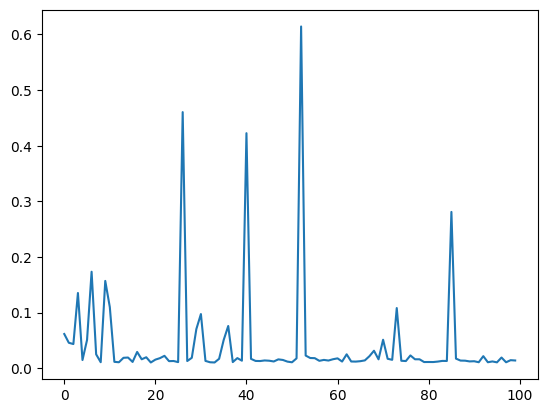

In [1113]:
plt.plot(sample['sampled_intensity'], label='sampled')

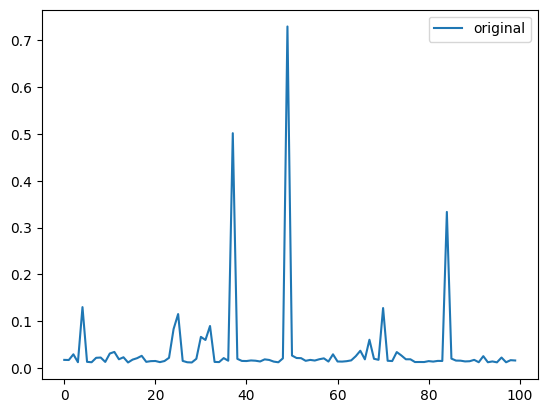

In [1114]:

plt.plot(sample['intensity_0'], label = 'original')
plt.legend()

## Instantiate the training

In [1115]:
# loss callback
losscallback = LossCallback(file_path=results_folder+f"loss.png")

In [1116]:
config.LR

0.001

In [1117]:
print("define model")

model = EmbedderMaldi(
        d_model=int(config.D_MODEL),
        n_layers=int(config.N_LAYERS),
        weights=None,
        lr=config.LR,
    )

define model


In [1118]:
# Define the ModelCheckpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=results_folder,
    filename="best_model",
    monitor="validation_loss_epoch",
    mode="min",
    save_top_k=1,
)

In [1119]:
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, losscallback],
    enable_progress_bar=True,
    # val_check_interval= config.validate_after_ratio,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Seed set to 42

  | Name             | Type                             | Params
----------------------------------------------------------------------
0 | linear           | Linear                           | 16.5 K
1 | linear_output    | Linear                           | 12.9 K
2 | shared_linear    | SharedLinear                     | 129   
3 | relu             | ReLU                             | 0     
4 | spectrum_encoder | SpectrumTransformerEncoderCustom | 1.7 M 
5 | cosine_loss      | CosineEmbeddingLoss              | 0     
6 | regression_loss  | MSELoss                          | 0     
7 | dropout          | Dropout                          | 0     
----------------------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.846     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/Users/sebas/projects/metabolomics/src/pretraining_maldi/embedder_maldi.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(batch["flips"]).to(self.device)


Train loss:
[]
Validation loss
[0.6942803263664246]


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.6942803263664246, 0.6819882988929749]


Validation: |                                                                                                 …

Train loss:
[0.6809244155883789]
Validation loss
[0.6942803263664246, 0.6819882988929749, 0.6760542392730713]


Validation: |                                                                                                 …

Train loss:
[0.6809244155883789, 0.6753472685813904]
Validation loss
[0.6942803263664246, 0.6819882988929749, 0.6760542392730713, 0.6748695969581604]


Validation: |                                                                                                 …

Train loss:
[0.6809244155883789, 0.6753472685813904, 0.6735366582870483]
Validation loss
[0.6942803263664246, 0.6819882988929749, 0.6760542392730713, 0.6748695969581604, 0.6732553243637085]


Validation: |                                                                                                 …

Train loss:
[0.6809244155883789, 0.6753472685813904, 0.6735366582870483, 0.6725252270698547]
Validation loss
[0.6942803263664246, 0.6819882988929749, 0.6760542392730713, 0.6748695969581604, 0.6732553243637085, 0.6725147366523743]


Validation: |                                                                                                 …

Train loss:
[0.6809244155883789, 0.6753472685813904, 0.6735366582870483, 0.6725252270698547, 0.6718289256095886]
Validation loss
[0.6942803263664246, 0.6819882988929749, 0.6760542392730713, 0.6748695969581604, 0.6732553243637085, 0.6725147366523743, 0.6715231537818909]


RuntimeError: Shared memory manager connection has timed out

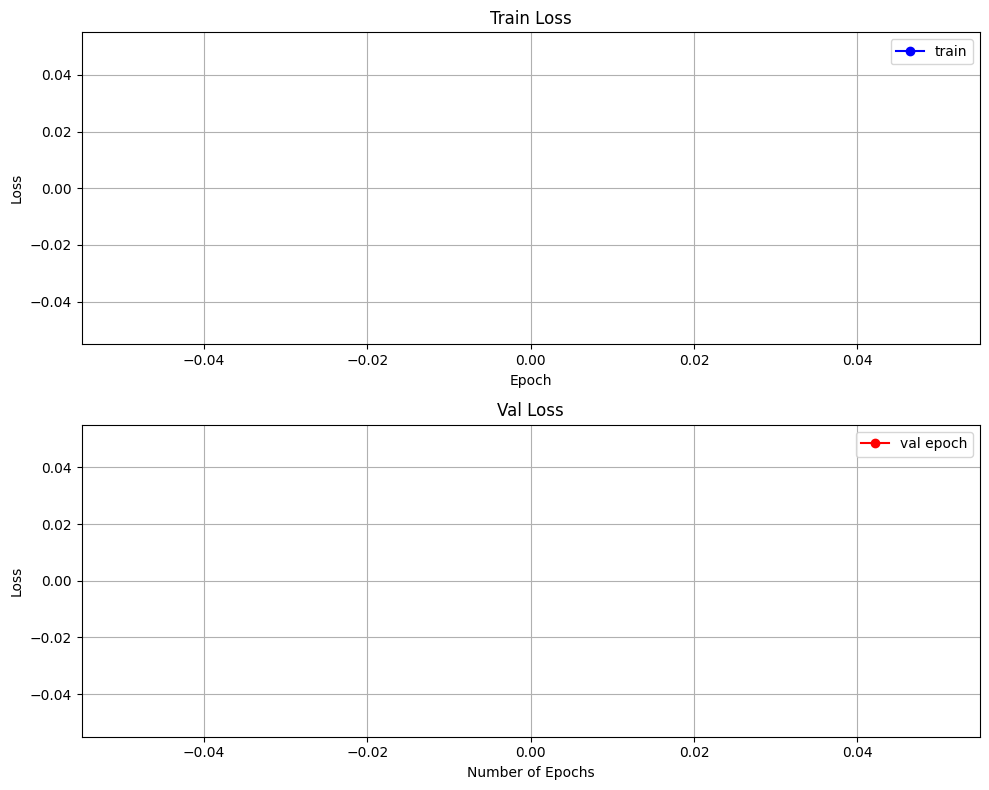

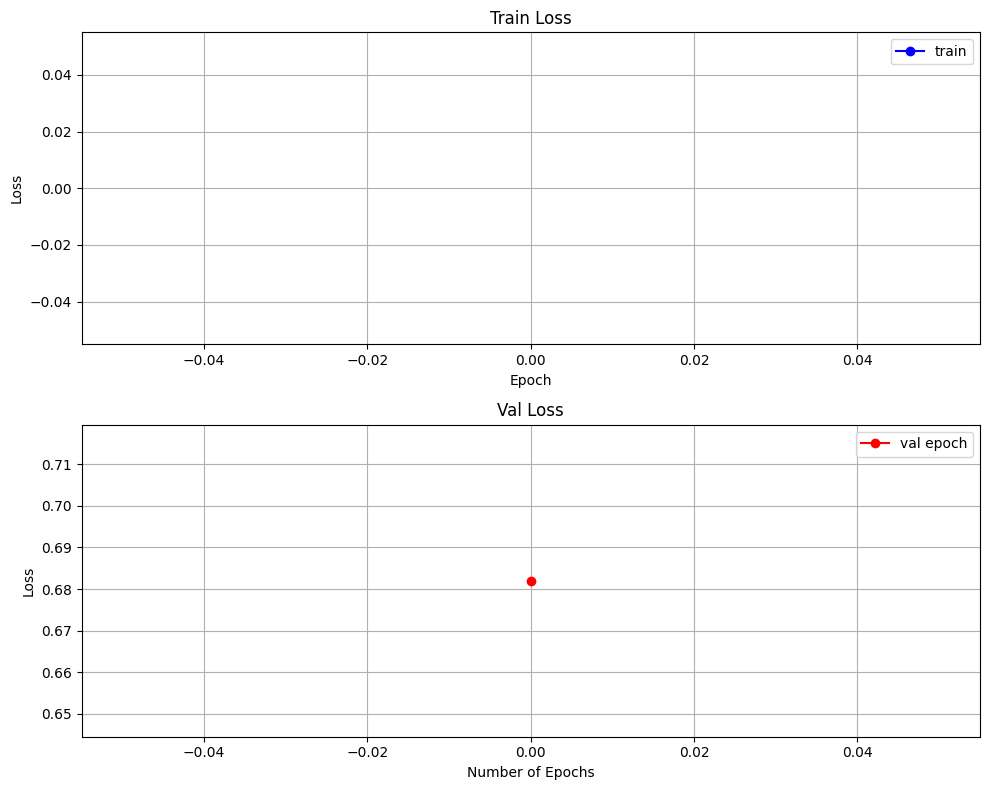

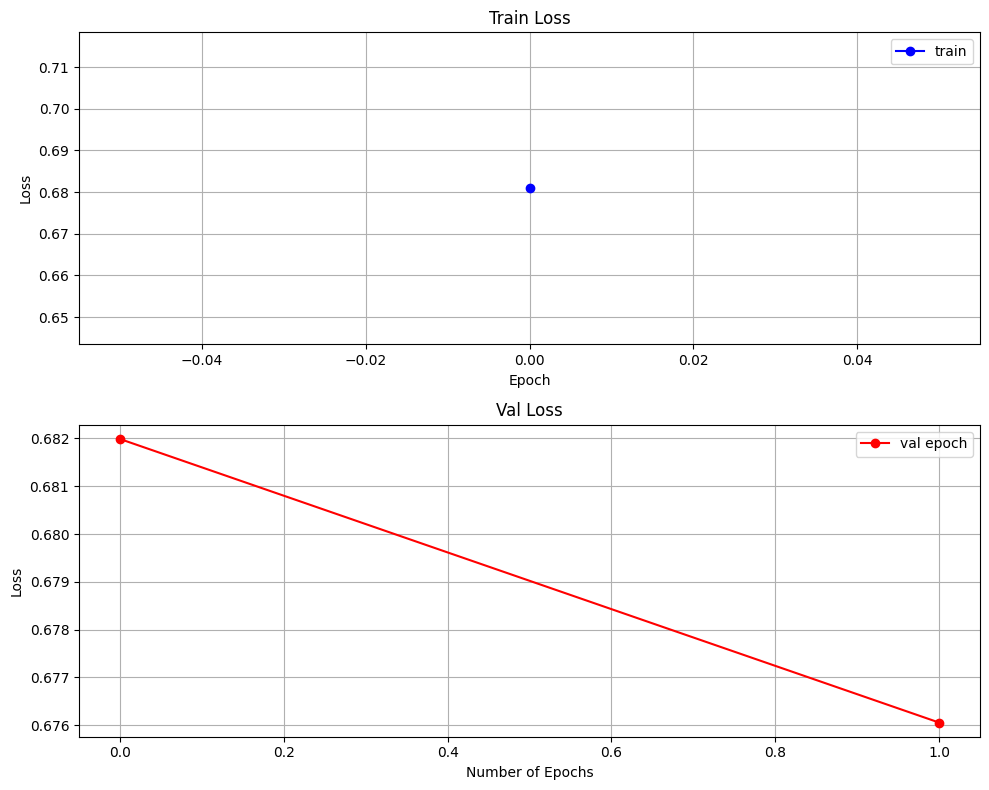

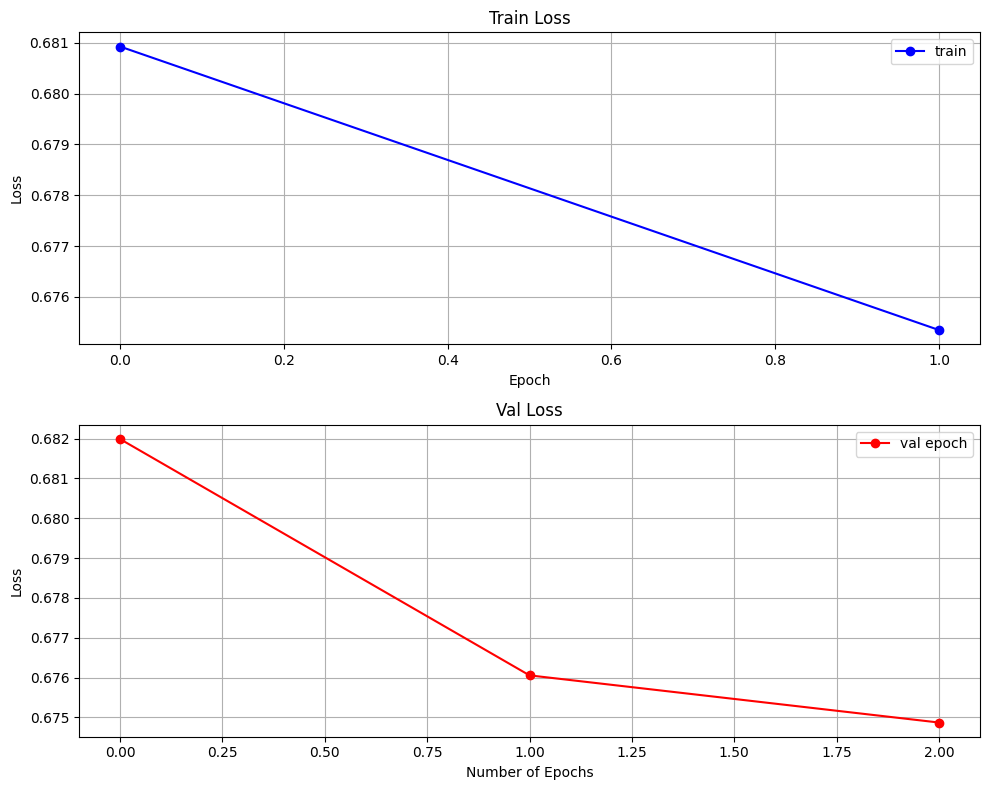

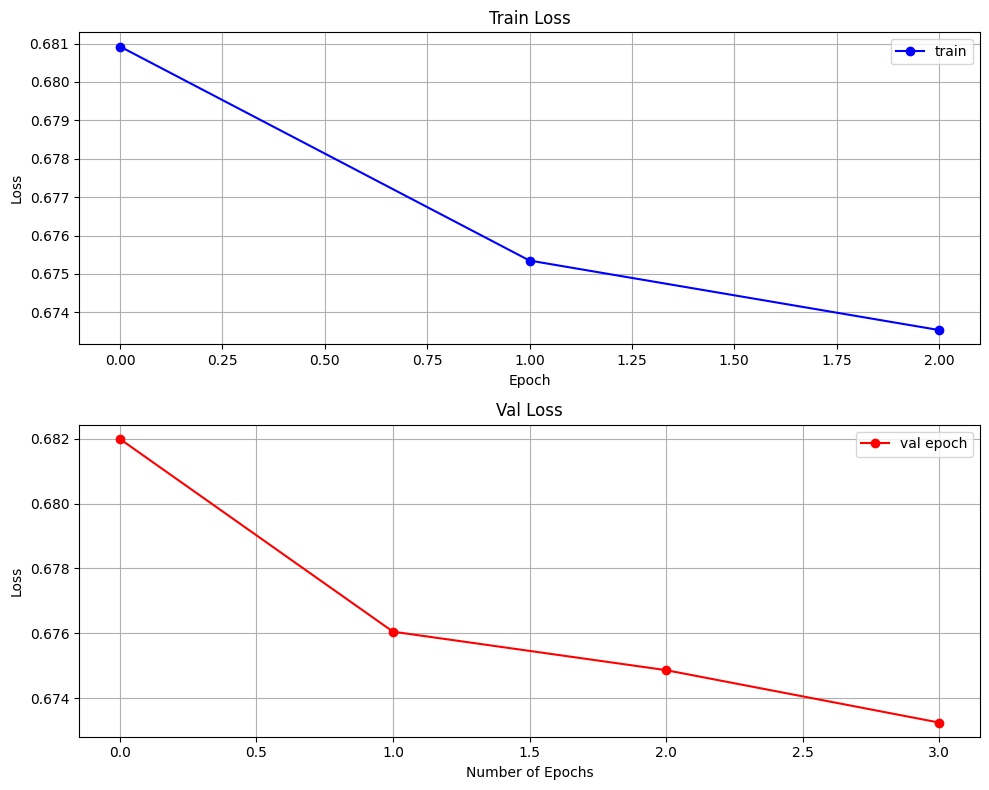

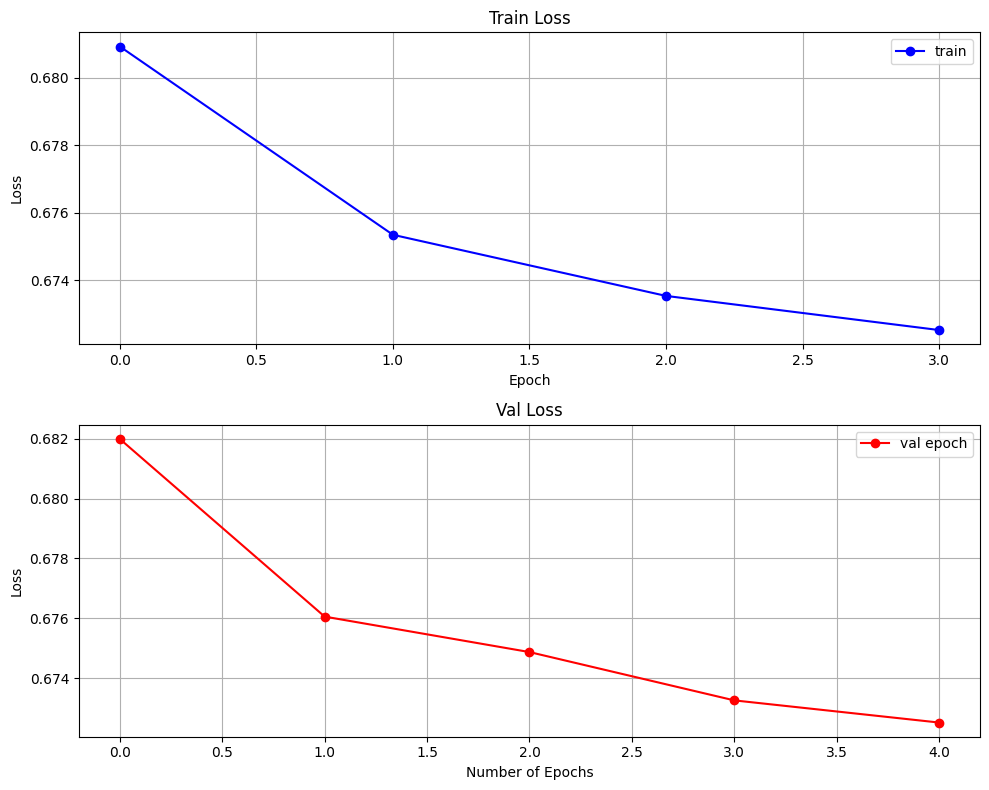

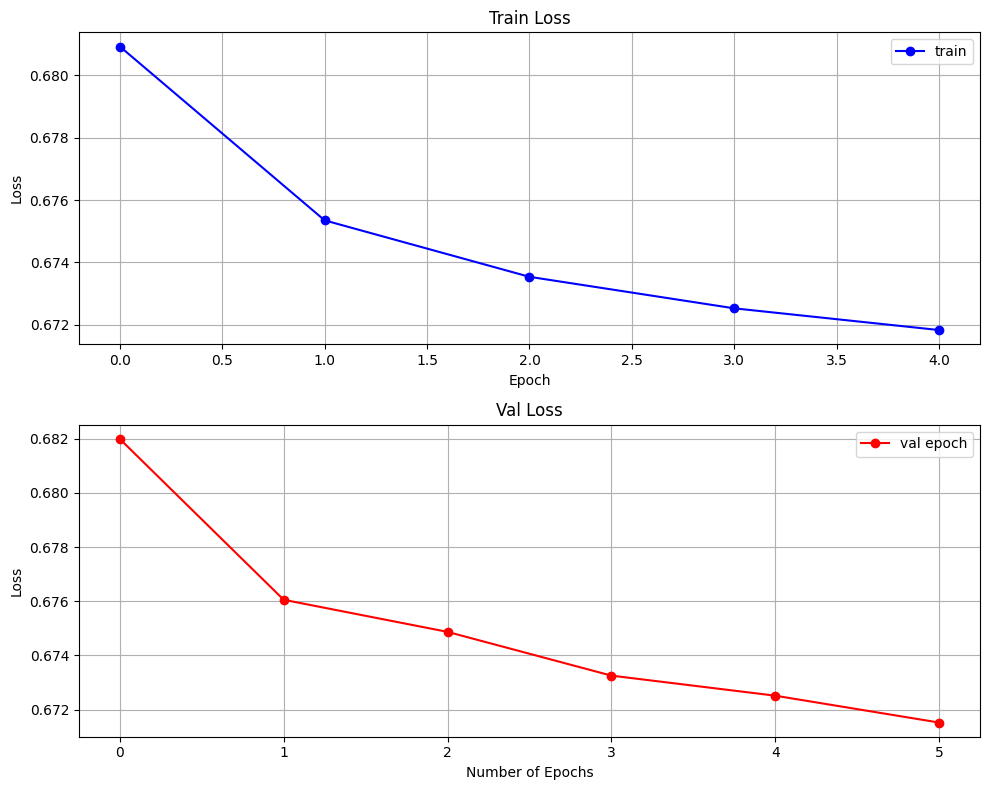

In [1123]:
# # trainer = pl.Trainer(max_steps=100,  callbacks=[checkpoint_callback, losscallback], enable_progress_bar=enable_progress_bar)
trainer.fit(
    model=model,
    train_dataloaders=(dataloader_train),
    val_dataloaders=dataloader_val,
)


In [ ]:
import numpy as np

In [ ]:
a=np.array([1,2,3,4])

In [ ]:
a[[2,3]]

In [ ]:
spectrums_train[0]

In [ ]:
from src.preprocessor import Preprocessor

In [ ]:
pp=Preprocessor()

In [ ]:
plt.plot(spectrums_train[0].intensity_array)

In [ ]:
spec_result = pp.preprocess_spectrum(spectrums_train[0], min_intensity=10)

In [ ]:
spectrums_train[0].intensity

In [ ]:
spectrums_train[0].intensity_array[0:20]

In [ ]:
spectrums_train[0].filter_intensity(min_intensity=0, max_num_peaks=100).intensity[0:20]

In [ ]:
spec_result=spectrums_train[0].scale_intensity('log')
spec_result.intensity_array[0:20]

In [ ]:
spectrums_train[0].intensity_array[0:20]

In [ ]:
plt.plot(spec_result.mz)

In [ ]:
plt.plot(spec_result.mz)

In [ ]:
plt.plot(spec_result.intensity)

In [ ]:
plt.plot(spec_result.intensity_array)

In [ ]:
from spectrum_utils.spectrum import MsmsSpectrum

In [ ]:
spec_msms = MsmsSpectrum(identifier, 
                         precursor_mz=, 
                         precursor_charge, 
                         mz, 
                         intensity, 
                         retention_time)

In [1124]:
list(2)

TypeError: 'int' object is not iterable